In [9]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression


plots_directory = f"plots"

EXPERIMENT_TYPE_STATIC = 1
EXPERIMENT_TYPE_DYNAMIC = 2
EXPERIMENT_TYPE_ONE_BY_ONE = 3


class ParamTypes:
    CPU = "CPU"
    MEMORY = "MEM"
    REPLICA = "REPLICA"
    BATCH = "BATCH"
    BATCH_TIMEOUT = "BATCH_TIMEOUT"
    MODEL_ARCHITECTURE = "ARCH"
    INTRA_OP_PARALLELISM = "INTRA_OP_PARALLELISM"
    INTER_OP_PARALLELISM = "INTER_OP_PARALLELISM"
    NUM_BATCH_THREADS = "NUM_BATCH_THREADS"
    HARDWARE = "HARDWARE"
    MAX_ENQUEUED_BATCHES = "MAX_ENQUEUED_BATCHES"

    @classmethod
    def get_all(cls):
        return [
            cls.CPU,
            cls.MEMORY,
            cls.REPLICA,
            cls.BATCH,
            cls.BATCH_TIMEOUT,
            cls.MODEL_ARCHITECTURE,
            cls.INTRA_OP_PARALLELISM,
            cls.INTER_OP_PARALLELISM,
            cls.HARDWARE,
            cls.NUM_BATCH_THREADS,
            cls.MAX_ENQUEUED_BATCHES,
        ]


def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    ax.legend(*zip(*unique))

# For paper



In [10]:
# !unzip results.zip

In [11]:
results_path = (
    f"results/capacity_result_Feb_21.csv"  # Every time, upload the file you want to use
)
df = pd.read_csv(results_path)
alpha = 0.05
baseline_accuracies = {
    18: 0.69758,
    34: 0.73314,
    50: 0.7613,
    101: 0.77374,
    152: 0.78312,
}
load_times = {
    18: 6.44,
    34: 6.79,
    50: 6.82,
    101: 7.77,
    152: 8.52,
}
dropping_columns = ["timestamp", ParamTypes.MAX_ENQUEUED_BATCHES]

df = df.drop(dropping_columns, axis=1)
slas = list(df["SLA"].unique())
versions = [18, 34, 50, 101, 152]
models = {v: {} for v in versions}
for version in versions:
    for sla in slas:
        df_sla = df[df["SLA"] == sla]
        X_train = np.array(
            df_sla[(df_sla["CPU"] <= 10) & (df_sla["ARCH"] == version)]["CPU"]
        ).reshape(-1, 1)
        Y_train = df_sla[(df_sla["CPU"] <= 10) & (df_sla["ARCH"] == version)][
            "capacity"
        ]

        model = LinearRegression()
        model.fit(X_train, Y_train)
        models[version][sla] = model

font = {"size": 12}

plt.rc("font", **font)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
color_list = ["#d7191c", "#fdae61", "#fee090", "#abd9e9", "#2c7bb6"]
df

,REPLICA,HARDWARE,CPU,MEM,ARCH,BATCH,NUM_BATCH_THREADS,INTRA_OP_PARALLELISM,INTER_OP_PARALLELISM,SLA,p99_latency,capacity,saturation_tp
0,1,cpu,1,1G,18,1,1,1,1,500,361.99,15,22
1,1,cpu,1,1G,18,1,1,1,1,750,389.09,19,22
2,1,cpu,1,1G,18,1,1,1,1,1000,389.09,19,22
3,1,cpu,1,1G,18,1,1,1,1,1500,703.29,21,22
4,1,cpu,1,1.25G,34,1,1,1,1,500,NaN,4,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,cpu,20,2G,101,1,20,1,20,1500,393.37,98,99
396,1,cpu,20,2.25G,152,1,20,1,20,500,391.72,64,74
397,1,cpu,20,2.25G,152,1,20,1,20,750,661.65,67,74
398,1,cpu,20,2.25G,152,1,20,1,20,1000,688.30,70,74


In [12]:
import numpy as np
from joblib import load


class Reconfiguration:
    def __init__(
        self,
        model_versions: list,
        max_cpu: int,
        df,
        baseline_accuracies: dict,
        load_times: dict,
        alpha: float,
        beta=0.2,
    ):
        self.__max_cpu = max_cpu
        self.__model_versions = sorted(model_versions)
        self.__baseline_accuracies = baseline_accuracies
        self.__load_times = load_times
        self.__alpha = alpha
        self.__beta = beta
        self.__min_cpu = 2
        self.__sla = 750
        self.df = df

    def regression_model(self, model_version, cpu):
        return int(
            self.df[
                (self.df["SLA"] == self.__sla)
                & (self.df["ARCH"] == model_version)
                & (self.df["CPU"] == cpu)
            ]["capacity"]
        )

    def find_all_valid_options(
        self, max_cpu, rate, models=None, option=None, options=None
    ):
        if models is None:
            models = self.__model_versions

        if option is None:
            option = []

        if options is None:
            options = []

        if rate <= 0:
            return option[:]

        for mi in range(len(models)):
            m = models[mi]
            ms = models[mi + 1 :]
            for c in range(self.__min_cpu, max_cpu + 1):
                p = self.find_all_valid_options(
                    max_cpu - c,
                    rate - self.regression_model(m, c),
                    ms,
                    option + [(m, c)],
                    options,
                )
                if p:
                    options.append(p)
        if models == self.__model_versions:
            return options

    def assign_shares_to_options_models(self, options, lmbda):
        options_with_shares = []
        for option in options:
            rate = lmbda
            with_share = []
            for model_choice in sorted(option, key=lambda x: x[0], reverse=True):
                model, cpu = model_choice
                capacity = min(self.regression_model(model, cpu), rate)
                share = capacity / lmbda
                rate -= capacity
                with_share.append((model, cpu, share))
            options_with_shares.append(with_share)
        return options_with_shares

    @staticmethod
    def convert_config_to_dict(config):
        d = {}
        for ms in config:
            m, c, _ = ms
            d[m] = c
        return d

    def transition_cost(self, model, current_option, new_option):
        current = self.convert_config_to_dict(current_option)
        new = self.convert_config_to_dict(new_option)
        if model not in new.keys():
            return 0
        if current.get(model) != new.get(model):
            return 1
        return 0

    def load_cost(self, current_option, new_option):
        lc = {
            v: self.transition_cost(v, current_option, new_option)
            * self.__load_times[v]
            for v in self.__model_versions
        }
        return max(lc.values()) / max(self.__load_times.values())

    def find_best_option(self, options_with_shares, prev_option):
        # Todo: add the effect of prev_option
        max_f = -100
        best_option = None
        for option_with_shares in options_with_shares:
            accuracy = 0
            cost = 0
            for model_choice in option_with_shares:
                model, cpu, share = model_choice
                accuracy += share * self.__baseline_accuracies[model]
                cost += cpu
            load_cost = self.load_cost(prev_option, option_with_shares)
            resource_cost = cost / self.__max_cpu
            f = accuracy - (self.__alpha * resource_cost + self.__beta * load_cost)
            if f > max_f:
                max_f = f
                best_option = option_with_shares
        return best_option

    def reconfig(self, lmbda, current_option):
        max_cpu = self.__max_cpu
        mamv = sorted(self.__model_versions)[-1]
        for cpu in range(self.__min_cpu, max_cpu + 1):
            if self.regression_model(mamv, cpu) >= lmbda:
                max_cpu = cpu
                break
        # print("max_cpu", max_cpu)
        all_options = self.find_all_valid_options(max_cpu, lmbda)
        all_options_with_shares = self.assign_shares_to_options_models(
            all_options, lmbda
        )
        # print("len", len(all_options_with_shares))
        best_option = self.find_best_option(all_options_with_shares, current_option)
        return best_option

    def reconfig_msp(self, lmbda, current_option):
        max_cpu = self.__max_cpu
        mamv = sorted(self.__model_versions)[-1]
        for cpu in range(self.__min_cpu, max_cpu + 1):
            if self.regression_model(mamv, cpu) >= lmbda:
                max_cpu = cpu
                break
        all_options = []
        for mv in self.__model_versions:
            for c in range(2, max_cpu + 1):
                if self.regression_model(mv, c) >= lmbda:
                    all_options.append([(mv, c, 1)])
                    break
        best_options = self.find_best_option(all_options, current_option)
        return best_options

/tmp/ipykernel_1368954/2328332214.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(


[0 1 2] [190, 78, 27]
[0 1 2] [344, 145, 49]
[0 1 2] [473, 200, 67]


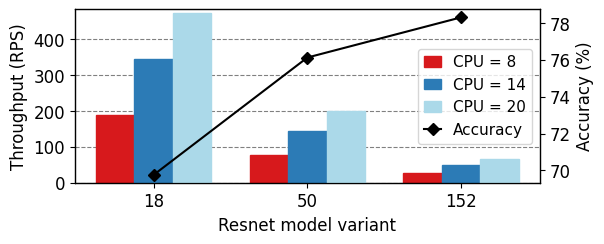

In [13]:
r = Reconfiguration(
    versions, None, df, baseline_accuracies, load_times, alpha=0, beta=0.0
)
fig, ax = plt.subplots(figsize=(6, 2.25))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()
width = 0.25
sla = 750

x_keys = [18, 50, 152]
costs = [8, 14, 20]

values = []
ax.set_xlabel("Resnet model variant")
ax.set_ylabel("Throughput (RPS)")
ax4.set_ylabel("Accuracy (%)")
values = [[r.regression_model(v, cost) for v in x_keys] for cost in costs]

values4 = [baseline_accuracies[v] * 100 for v in x_keys]

x_len = len(values)
x = np.arange(x_len)

ax.set_xticks(x)
ax.set_xticklabels(x_keys)
print(x, values[0])
print(x, values[1])
print(x, values[2])
bars = ax.bar(x - width, values[0], width)
bars2 = ax2.bar(x, values[1], width)
bars3 = ax3.bar(x + width, values[2], width)
ax.set_axisbelow(True)
ax.grid(axis="y", color="gray", linestyle="dashed")
ax2.set_axisbelow(True)
ax2.grid(axis="y", color="gray", linestyle="dashed")
ax3.set_axisbelow(True)
ax3.grid(axis="y", color="gray", linestyle="dashed")
acc_plot = ax4.plot(
    np.arange(x_len), values4, color="black", marker="D", label="Accuracy"
)

for i in range(len(bars)):
    color = color_list[0]
    bars[i].set_color(color)

for i in range(len(bars)):
    color = color_list[-1]
    bars2[i].set_color(color)

for i in range(len(bars)):
    color = color_list[-2]
    bars3[i].set_color(color)

patches = []
for i in range(len(costs)):
    patches.append(mpatches.Patch(color=color_list[-i], label=f"CPU = {costs[i]}"))

plt.legend(handles=[*patches, acc_plot[0]], loc="right", handlelength=1.1, fontsize=11)

ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_yaxis().set_visible(True)
ax.set_ylim([0, max(values[-1]) + 10])
ax2.set_ylim([0, max(values[-1]) + 10])
ax3.set_ylim([0, max(values[-1]) + 10])

plt.savefig("variant-cpu.pdf", dpi=600, format="pdf", bbox_inches="tight", pad_inches=0)

/tmp/ipykernel_1368954/2328332214.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(


infadapter 8 [(101, 2, 0.136986301369863), (50, 6, 0.863013698630137)]
msp 8 [(50, 8, 1)]
infadapter 14 [(152, 6, 0.3424657534246575), (101, 6, 0.4246575342465753), (50, 2, 0.2328767123287671)]
msp 14 [(50, 8, 1)]
infadapter 20 [(152, 16, 0.8082191780821918), (101, 3, 0.1917808219178082)]
msp 20 [(101, 15, 1)]


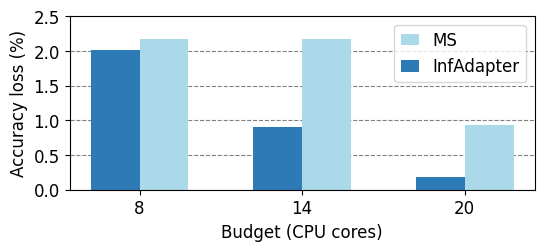

In [14]:
def get_cost_acc(opt):
    accuracy = 0
    cost = 0
    for model_choice in opt:
        model, cpu, share = model_choice
        accuracy += share * baseline_accuracies[model]
        cost += cpu
    return cost, accuracy


budgets = {}
budgets_msp = {}

lmbda = 73
budget_list = [8, 14, 20]
base_acc = baseline_accuracies[152]
for budget in budget_list:
    r = Reconfiguration(
        versions, budget, df, baseline_accuracies, load_times, alpha=0, beta=0.0
    )
    config = r.reconfig(lmbda, [(18, 1, 1)])
    cost, acc = get_cost_acc(config)
    print("infadapter", budget, config)
    budgets[budget] = base_acc * 100 - acc * 100

    config = r.reconfig_msp(lmbda, [(18, 1, 1)])
    cost, acc = get_cost_acc(config)
    print("msp", budget, config)
    budgets_msp[budget] = base_acc * 100 - acc * 100

x = np.arange(len(budget_list))
fig, ax = plt.subplots(figsize=(6, 2.25))
width = 0.3

ax.set_xticks(x)
ax.set_xticklabels(list(budgets.keys()))
ax.set_ylim([0, 2.5])
ax.bar(
    x + width / 2, list(budgets_msp.values()), width, label=f"MS", color=color_list[-2]
)
ax.bar(
    x - width / 2,
    list(budgets.values()),
    width,
    label=f"InfAdapter",
    color=color_list[-1],
)
ax.set_axisbelow(True)
ax.grid(axis="y", color="gray", linestyle="dashed")

mn = baseline_accuracies[18] * 100
mx = baseline_accuracies[152] * 100 - mn
# ax.set_ylim([0, mx])

ax.set_xlabel("Budget (CPU cores)")
ax.set_ylabel("Accuracy loss (%)")
plt.legend(handlelength=1.1, fontsize=12)
# fig.tight_layout()
plt.savefig(
    "infadapter-msp-accuracy-loss.pdf",
    dpi=600,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0,
)

In [15]:
INFADAPTER = "InfAdapter"
MSPLUS = "MS+"
VPA18 = "VPA-18"
VPA34 = "VPA-34"
VPA50 = "VPA-50"
VPA101 = "VPA-101"
VPA152 = "VPA-152"

colors = {
    INFADAPTER: color_list[-1],
    MSPLUS: color_list[-2],
    VPA18: color_list[1],
    VPA50: color_list[2],
    VPA152: color_list[0],
}

markers = {
    INFADAPTER: ".",
    MSPLUS: None,
    VPA18: None,
    VPA34: None,
    VPA50: None,
    VPA101: None,
    VPA152: None,
}

In [16]:
!unzip lstm_saved_model.zip

unzip:  cannot find or open lstm_saved_model.zip, lstm_saved_model.zip.zip or lstm_saved_model.zip.ZIP.


In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# tf.random.set_seed(7)

2023-05-26 21:42:29.848003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 21:42:30.002918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-26 21:42:30.002940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-26 21:42:30.033508: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-26 21:42:31.195623: W tensorflow/stream_executor/pla

**LSTM**
--

In [18]:
lstm_model = load_model(f"/home/cc/infernece-pipeline-joint-optimization/data/lstm")


def get_x_y(data):
    x = []
    y = []
    for i in range(10):
        data.insert(0, data[0])
    for i in range(0, len(data) - 10):
        x.extend(data[i : i + 10])
        y.append(data[i + 10])
    x = np.array(x)
    print("shapes")
    print(x.shape)
    print(len(y))
    return tf.convert_to_tensor(x.reshape((-1, 10, 1)), dtype=tf.float32), y

2023-05-26 21:42:32.636876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-26 21:42:32.636907: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-26 21:42:32.636924: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (microk8s-cluster-1): /proc/driver/nvidia/version does not exist
2023-05-26 21:42:32.637293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
def plot_for_alpha(alpha, wl_type):
    filenames = {
        INFADAPTER: f"results/infadapter-alpha{alpha}-SLO750-{wl_type}",
        MSPLUS: f"results/msp-alpha{alpha}-SLO750-{wl_type}",
        VPA18: f"results/vpa-18-{wl_type}",
        VPA34: f"results/vpa-34-{wl_type}",
        VPA50: f"results/vpa-50-{wl_type}",
        VPA101: f"results/vpa-101-{wl_type}",
        VPA152: f"results/vpa-152-{wl_type}",
    }

    dfs = {}

    for exp, fn in filenames.items():
        dfs[exp] = pd.read_csv(f"{fn}/series.csv")

    x_len = len(list(dfs.values())[0]["accuracy"])
    print("len x", x_len)

    fig, axs = plt.subplots(4, 1, figsize=(6, 9))
    axs_idx = 0
    for metric in ["rate", "99", "accuracy", "cost"]:
        ax = axs[axs_idx]
        ax.grid(axis="y", linestyle="dashed", color="gray")
        axs_idx += 1
        if metric == "99":
            ax.plot(
                list(range(x_len)),
                [0.75 for _ in range(x_len)],
                linestyle="dashed",
                label="750 ms",
                color="green",
            )
            ylabel = "P99-Latency (s)"
            ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
            ax.set_ylim([0, 2.5])
        elif metric == "accuracy":
            ylabel = "Accuracy loss (%)"
            ax.set_ylim([-0.5, 10])
            ax.set_yticks([0, 2, 4, 6, 8, 10])
        elif metric == "rate":
            ylabel = "Workload (RPS)"
            ax.set_ylim([0, 250])
            ax.set_yticks([0, 50, 100, 150, 200, 250])
        else:
            ylabel = "Cost (CPU cores)"
            ax.set_ylim([0, 22])
            ax.set_yticks([0, 5, 10, 15, 20])

        for exp, df in dfs.items():
            if exp not in [INFADAPTER, VPA18, MSPLUS, VPA152, VPA50]:
                continue
            metric_values = df[metric]
            if metric == "accuracy":
                metric_values = (baseline_accuracies[152] - metric_values) * 100

            marker = markers[exp]
            if metric in ["99", "rate"]:
                marker = None
            if metric != "rate":
                ax.plot(
                    list(range(len(metric_values))),
                    metric_values,
                    label=exp,
                    marker=marker,
                    color=colors[exp],
                )
            else:
                x, y = get_x_y(list(df["rate"]))
                print(len(y), len(df["rate"]))
                pred_y = list(lstm_model.predict(x))
                print(len(pred_y), "pred_y")
                ax.plot(
                    list(range(len(metric_values))),
                    metric_values,
                    label="real",
                    marker=marker,
                    color="dimgray",
                )
                ax.plot(
                    list(range(len(metric_values))),
                    pred_y,
                    label="prediction",
                    marker=None,
                    color="lightgray",
                )
                ax.legend()
                break

        fig.canvas.draw()
        # labels = [item.get_text() for item in ax.get_xticklabels()]
        # labels[0] = "-" + labels[0][1:]
        # labels = list(map(lambda x: int(x) * 5, labels))

        ax.set_ylabel(ylabel)
        if axs_idx < 4:
            labels = []
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Time (s)")
        ax.set_xlim([-5, 245])
        ax.set_xticks([i for i in range(0, 245, 40)], [i for i in range(0, 1201, 200)])

    plt.legend(
        fontsize=12,
        fancybox=False,
        ncol=5,
        frameon=False,
        bbox_to_anchor=(1.02, 4.9),
        handlelength=0.6,
        columnspacing=0.6,
    )
    fig.tight_layout()
    fig.savefig(
        f"comparison-{alpha}-{wl_type}.pdf",
        dpi=600,
        format="pdf",
        bbox_inches="tight",
        pad_inches=0,
    )

alpha = 0.2
--

len x 242
shapes
(2420,)
242
242 242
8/8 [==============================] - 0s 3ms/step
242 pred_y


/tmp/ipykernel_1368954/1216659746.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


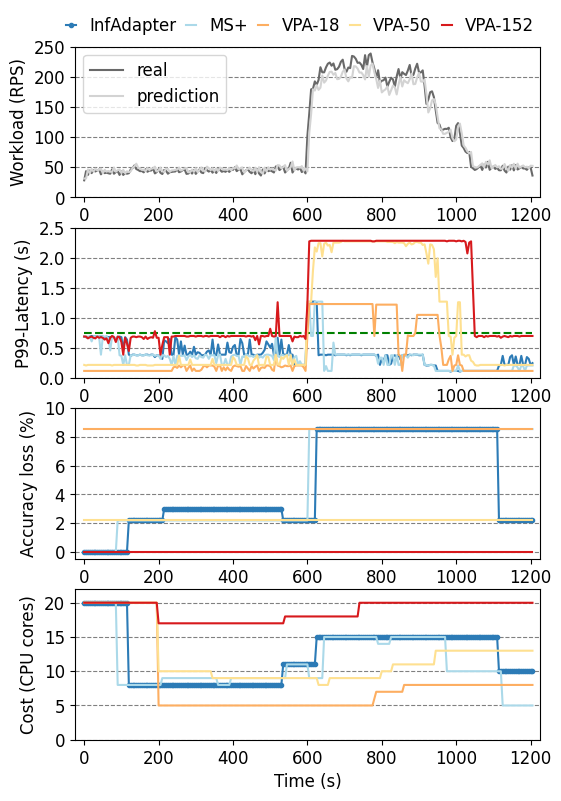

In [26]:
plot_for_alpha(0.2, "bursty")

alpha = 0.05
--

len x 242
shapes
(2420,)
242
242 242
8/8 [==============================] - 0s 3ms/step
242 pred_y


/tmp/ipykernel_1368954/1216659746.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


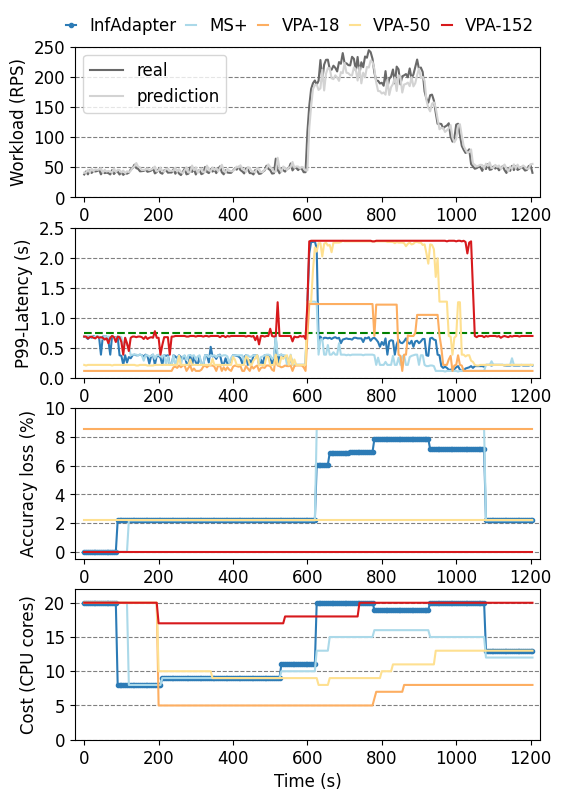

In [21]:
plot_for_alpha(0.05, "bursty")

alpha = 0.0125
--

len x 242
shapes
(2420,)
242
242 242
8/8 [==============================] - 0s 5ms/step
242 pred_y


/tmp/ipykernel_1368954/1216659746.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


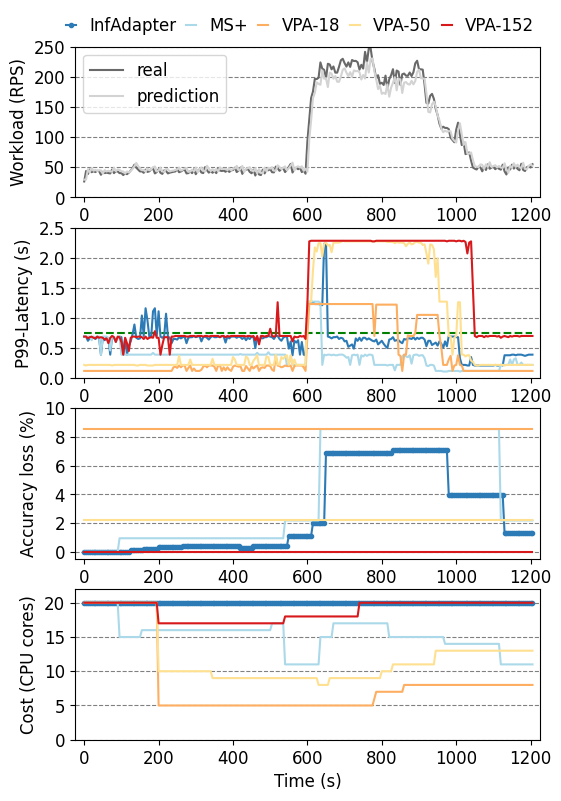

In [22]:
plot_for_alpha(0.0125, "bursty")

In [23]:
def plog_agg(wl_type):
    filenames_0125 = {
        INFADAPTER: f"results/infadapter-alpha0.0125-SLO750-{wl_type}",
        MSPLUS: f"results/msp-alpha0.0125-SLO750-{wl_type}",
        VPA18: f"results/vpa-18-{wl_type}",
        VPA34: f"results/vpa-34-{wl_type}",
        VPA50: f"results/vpa-50-{wl_type}",
        VPA101: f"results/vpa-101-{wl_type}",
        VPA152: f"results/vpa-152-{wl_type}",
    }
    filenames_05 = {
        INFADAPTER: f"results/infadapter-alpha0.05-SLO750-{wl_type}",
        MSPLUS: f"results/msp-alpha0.05-SLO750-{wl_type}",
        VPA18: f"results/vpa-18-{wl_type}",
        VPA34: f"results/vpa-34-{wl_type}",
        VPA50: f"results/vpa-50-{wl_type}",
        VPA101: f"results/vpa-101-{wl_type}",
        VPA152: f"results/vpa-152-{wl_type}",
    }
    filenames_2 = {
        INFADAPTER: f"results/infadapter-alpha0.2-SLO750-{wl_type}",
        MSPLUS: f"results/msp-alpha0.2-SLO750-{wl_type}",
        VPA18: f"results/vpa-18-{wl_type}",
        VPA34: f"results/vpa-34-{wl_type}",
        VPA50: f"results/vpa-50-{wl_type}",
        VPA101: f"results/vpa-101-{wl_type}",
        VPA152: f"results/vpa-152-{wl_type}",
    }
    dfs_0125 = {}
    dfs_05 = {}
    dfs_2 = {}
    for exp, fn in filenames_0125.items():
        dfs_0125[exp] = pd.read_csv(f"{fn}/series.csv")
    for exp, fn in filenames_05.items():
        if exp not in [INFADAPTER, MSPLUS]:
            dfs_05[exp] = dfs_0125[exp]
        else:
            dfs_05[exp] = pd.read_csv(f"{fn}/series.csv")
    for exp, fn in filenames_2.items():
        if exp not in [MSPLUS, INFADAPTER]:
            dfs_2[exp] = dfs_0125[exp]
        else:
            dfs_2[exp] = pd.read_csv(f"{fn}/series.csv")
    total_requests = 121697
    if wl_type == "bursty":
        total_results = {
            VPA18: {"accuracy": [0.6976] * 3, "cost": [8.49] * 3},
            VPA34: {"accuracy": [0.7331] * 3, "cost": [11.18] * 3},
            VPA50: {"accuracy": [0.7613] * 3, "cost": [12.02] * 3},
            VPA101: {"accuracy": [0.7737] * 3, "cost": [15.91] * 3},
            VPA152: {"accuracy": [0.7831] * 3, "cost": [18.83] * 3},
            INFADAPTER: {
                "accuracy": [0.7354, 0.7439, 0.7559],
                "cost": [12.44, 14.34, 20.0],
            },
            MSPLUS: {
                "accuracy": [0.7313, 0.7395, 0.7421],
                "cost": [11.3, 12.75, 15.26],
            },
        }
    else:
        total_results = {
            VPA18: {"accuracy": [0.6976] * 3, "cost": [12.27] * 3},
            VPA34: {"accuracy": [0.7331] * 3, "cost": [20.0] * 3},
            VPA50: {"accuracy": [0.7613] * 3, "cost": [18.57] * 3},
            VPA101: {"accuracy": [0.7737] * 3, "cost": [15.91] * 3},
            VPA152: {"accuracy": [0.7831] * 3, "cost": [18.83] * 3},
            INFADAPTER: {
                "accuracy": [0.7354911580594673, 0.7439543818466351, 0.755932942097027],
                "cost": [12.44, 14.34, 20.0],
            },
            MSPLUS: {
                "accuracy": [0.7313879499217525, 0.7395086922474541, 0.742177055599061],
                "cost": [11.3, 12.75, 15.26],
            },
        }

    percentile_list = [
        99,
        98,
        97,
        96,
        95,
        90,
        85,
        80,
        75,
        70,
        65,
        60,
        55,
        50,
        40,
        30,
        20,
        10,
    ]
    rates_5s = list(dfs_2[INFADAPTER]["rate"])

    violations = {}
    # timeouts = {}  # Dropped by tfserving queue manager
    percentiles = {}
    for p in percentile_list:
        percentiles[p] = {}
        for exp in dfs_2.keys():
            percentiles[p][exp] = {}
    for beta in [0.2, 0.05, 0.0125]:
        if beta == 0.2:
            dfs = dfs_2
        elif beta == 0.05:
            dfs = dfs_05
        else:
            dfs = dfs_0125

        for exp in dfs.keys():
            df = dfs[exp]
            # timeouts[exp] = {}
            violations[exp] = {}
            for p in percentile_list:
                percentiles[p][exp][beta] = list(df[f"{p}"])

    for beta in [0.2, 0.05, 0.0125]:
        total = 0
        for i in range(len(rates_5s)):
            total += rates_5s[i] * 5
            for exp in dfs.keys():
                if violations[exp].get(beta) is None:
                    violations[exp][beta] = 0
                found = False
                for p in percentile_list:
                    ps = percentiles[p][exp][beta]
                    if math.isnan(ps[i]):
                        found = False
                        break
                    if ps[i] < 0.75:
                        found = True
                        violations[exp][beta] += (99 - p) * rates_5s[i] * 5 / 100
                        break
                if found is False:
                    violations[exp][beta] += 0.99 * rates_5s[i] * 5

        for exp in violations.keys():
            diff = total_requests - total
            violations[exp][beta] = 100 * violations[exp][beta] / total
            # timeouts[exp].append(
            #     100 * (total - (total_results[exp]["successful_requests"] - diff))
            #     / total
            # )

    print("violations", violations)
    # print("timeouts", timeouts)

    aggregated = {}
    for exp in violations.keys():
        if aggregated.get(exp) is None:
            aggregated[exp] = {}
        aggregated[exp] = {
            "success": {k: 100 - v for k, v in violations[exp].items()},
            "violations": violations[exp],
            # "dropped": timeouts[exp],
            "cost": total_results[exp]["cost"],
            "accuracy": total_results[exp]["accuracy"],
        }

    print(aggregated)

    fig, axs = plt.subplots(3, 1, figsize=(6, 6.75))
    axs_idx = 0
    for metric in ["accuracy", "cost", "violation"]:
        cc = []
        ax = axs[axs_idx]
        ax.set_axisbelow(True)
        ax.grid(axis="y", color="gray", linestyle="dashed")
        axs_idx += 1
        if metric == "violation":
            ylabel = "SLO violation (%)"
        elif metric == "accuracy":
            ylabel = "Accuracy loss (%)"
        else:
            ylabel = "Cost (CPU cores)"
            ax.set_ylim([0, 20])
            # ax.legend()

        x = np.arange(3)  # number of betas
        bars = []
        violation_bars = {"success": [], "violation": []}
        width = 0.15
        multiplier = -2
        for exp, df in dfs.items():
            if exp not in [INFADAPTER, VPA18, VPA50, VPA152, MSPLUS]:
                continue
            cc.append(colors[exp])
            if metric == "violation":
                violation_bars["success"] = list(aggregated[exp]["success"].values())
                violation_bars["violation"] = list(
                    aggregated[exp]["violations"].values()
                )
                bottom = np.zeros(3)
                offset = width * multiplier
                # for stack in violation_bars.keys():
                # kwargs = {}
                # if stack == "violation":
                #   kwargs["edgecolor"] = "black"
                #   kwargs["color"] = "grey"
                #   kwargs["hatch"] = "X"
                #   if exp == VPA152:
                #     kwargs["label"] = "violation"
                # else:
                #   kwargs["color"] = colors[exp]
                #   kwargs["label"] = exp
                bar_plots = ax.bar(
                    x + offset,
                    violation_bars["violation"],
                    width,
                    bottom=bottom,
                    label=exp,
                    color=colors[exp],
                )
                # bottom += np.array(violation_bars[stack])
            elif metric == "accuracy":
                acc = aggregated[exp][metric]
                bars = [(baseline_accuracies[152] - acc_i) * 100 for acc_i in acc]
                for i in range(len(bars)):
                    if bars[i] < 0.01:
                        bars[i] = 0.1
                offset = width * multiplier
                bar_plots = ax.bar(
                    x + offset, bars, width, color=colors[exp], label=exp
                )
            else:
                bars = aggregated[exp][metric]
                offset = width * multiplier
                bar_plots = ax.bar(
                    x + offset, bars, width, color=colors[exp], label=exp
                )
            multiplier += 1

        fig.canvas.draw()

        ax.set_ylabel(ylabel)
        if axs_idx < 3:
            labels = []
        else:
            labels = ["\u03B2=0.2", "\u03B2=0.05", "\u03B2=0.0125"]
        ax.set_xticks(x, labels)
    # ax.legend(loc="lower left")
    plt.legend(
        fontsize=13,
        fancybox=False,
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.93, 3.88),
        handlelength=1,
        columnspacing=0.8,
    )
    fig.tight_layout()
    fig.savefig(
        f"comparison-agg-{wl_type}.pdf",
        dpi=600,
        format="pdf",
        bbox_inches="tight",
        pad_inches=0,
    )

Aggregated fig
--

violations {'InfAdapter': {0.2: 0.0, 0.05: 0.005668363112244969, 0.0125: 0.0031735781032786762}, 'MS+': {0.2: 0.0, 0.05: 0.0, 0.0125: 0.0}, 'VPA-18': {0.2: 0.0, 0.05: 0.0, 0.0125: 0.0}, 'VPA-34': {0.2: 0.0, 0.05: 0.0, 0.0125: 0.0}, 'VPA-50': {0.2: 31.19812400912297, 0.05: 31.19812400912297, 0.0125: 31.19812400912297}, 'VPA-101': {0.2: 69.75989247578873, 0.05: 69.75989247578873, 0.0125: 69.75989247578873}, 'VPA-152': {0.2: 82.88490351499202, 0.05: 82.88490351499202, 0.0125: 82.88490351499202}}
{'InfAdapter': {'success': {0.2: 100.0, 0.05: 99.99433163688775, 0.0125: 99.99682642189673}, 'violations': {0.2: 0.0, 0.05: 0.005668363112244969, 0.0125: 0.0031735781032786762}, 'cost': [12.44, 14.34, 20.0], 'accuracy': [0.7354911580594673, 0.7439543818466351, 0.755932942097027]}, 'MS+': {'success': {0.2: 100.0, 0.05: 100.0, 0.0125: 100.0}, 'violations': {0.2: 0.0, 0.05: 0.0, 0.0125: 0.0}, 'cost': [11.3, 12.75, 15.26], 'accuracy': [0.7313879499217525, 0.7395086922474541, 0.742177055599061]}, 'VPA-

/tmp/ipykernel_1368954/3856747719.py:256: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


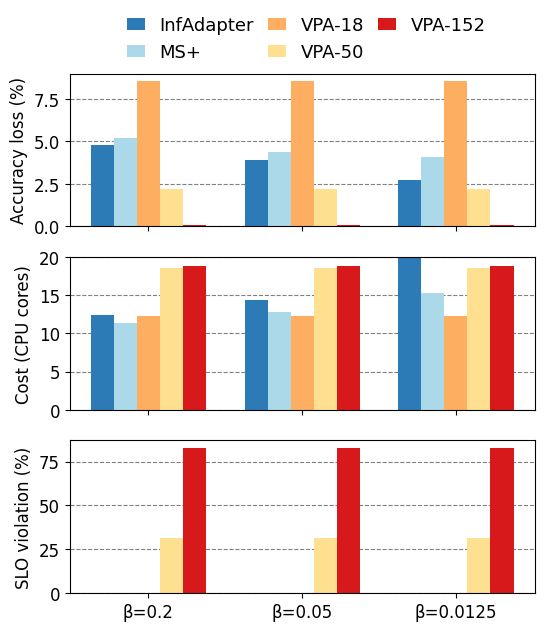

In [24]:
plog_agg("nonbursty")

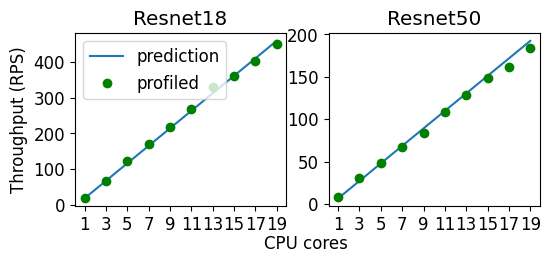

In [25]:
from sklearn.linear_model import LinearRegression

dfx = pd.read_csv(f"results/capacity_result_Feb_21.csv")

sla = 750

versions = [18, 34, 50, 101, 152]
models = {v: {} for v in versions}
for version in versions:
    df_sla = dfx[dfx["SLA"] == sla]
    df_sla = df_sla.query("CPU in (1,2,4,8,16)")
    X_train = np.array(df_sla[(df_sla["ARCH"] == version)]["CPU"]).reshape(-1, 1)
    Y_train = df_sla[(df_sla["ARCH"] == version)]["capacity"]

    model = LinearRegression()
    model.fit(X_train, Y_train)
    models[version][sla] = model

fig, axes = plt.subplots(1, 2, figsize=(6, 2.25))
idx = 0
for version in [18, 50]:
    ax = axes[idx]
    model = models[version][sla]
    df_sla = df[df["SLA"] == sla]
    X_test = np.array(df_sla[df_sla["ARCH"] == version]["CPU"]).reshape(-1, 1)

    y_pred = model.predict(X_test)
    ax.set_title(f"Resnet{version}")
    ax.plot(list(range(1, 21, 2)), y_pred[::2], label="prediction")
    ax.plot(
        list(range(1, 21, 2)),
        df_sla[df_sla["ARCH"] == version]["capacity"][::2],
        "go",
        label="profiled",
    )

    ax.set_xticks(list(range(1, 21, 2)))
    if idx == 0:
        ax.set_ylabel("Throughput (RPS)")
        ax.legend()
    idx += 1

fig.text(0.51, -0.08, "CPU cores", ha="center")
# fig.tight_layout()
fig.savefig(
    "linear-regression-accuracy.pdf",
    dpi=600,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0,
)